In [1]:
import numpy as np
import matplotlib.pyplot as plt
from build_mfea import GraphDomain

In [2]:
import os

sc = "Datasets/IDPCDU_Edges/set1/"
TaskNames = os.listdir(sc)
TaskNames.sort()

for i in range(24):
    print(i, TaskNames[i])

0 idpc_10x10x1000.idpc
1 idpc_10x20x2713.idpc
2 idpc_10x5x425.idpc
3 idpc_15x15x3375.idpc
4 idpc_15x30x12111.idpc
5 idpc_15x7x1504.idpc
6 idpc_20x10x2492.idpc
7 idpc_20x20x8000.idpc
8 idpc_20x40x26104.idpc
9 idpc_25x12x4817.idpc
10 idpc_25x25x15625.idpc
11 idpc_25x50x57147.idpc
12 idpc_30x15x10025.idpc
13 idpc_30x30x27000.idpc
14 idpc_30x60x89772.idpc
15 idpc_35x17x13934.idpc
16 idpc_35x35x42875.idpc
17 idpc_35x70x123585.idpc
18 idpc_40x20x18485.idpc
19 idpc_40x40x64000.idpc
20 idpc_40x80x130681.idpc
21 idpc_45x22x43769.idpc
22 idpc_45x45x91125.idpc
23 idpc_45x90x322081.idpc


In [3]:
def Load_data(taskIDs):
    Tasks = [0, 0]
    MAX_DIM = 0

    for i in range(2):
        path = sc + TaskNames[taskIDs[i]] 
        Tasks[i] = GraphDomain(path,name=TaskNames[taskIDs[i]])
        MAX_DIM = max(MAX_DIM, Tasks[i].NUM_DOMAIN)

    return Tasks, MAX_DIM

In [4]:
Tasks, D= Load_data([2, 3])

In [5]:
Tasks[1].NUM_DOMAIN

15

In [6]:
def Factorial_Cost(indiv, t):
    if t == 0:
        return Tasks[0].Cost(indiv)
    elif t == 1:
        return Tasks[1].Cost(indiv)
    else:
        return Tasks[0].Cost(indiv), Tasks[1].Cost(indiv)

In [7]:
# mark_tsp = set()
# mark_kp = set()

# def check_generated(individual, t = 2):
#     res = False

#     if t == 0 or t == 2:
#         tsp = decode_TSP(individual)
#         hash_val = hash(tsp.tobytes())
#         pre_size = len(mark_tsp)
#         mark_tsp.add(hash_val)
#         if(pre_size == len(mark_tsp)): res = True

#     if t == 1 or t == 2:
#         kp = decode_KP(individual)
#         hash_val = hash(kp.tobytes())
#         pre_size = len(mark_kp)
#         mark_kp.add(hash_val)
#         if(pre_size == len(mark_kp)): res = True
    
#     return res

In [8]:
def GeneratorIndiv(dims=D):
    indiv = np.random.permutation(range(dims)) + 1
    # while check_generated(indiv):
    #     indiv = np.random.random_sample((dims, ))
    
    return indiv, Factorial_Cost(indiv, t=2)

In [9]:
def Generate_Eval(sizePop):
    population = []
    tsp_cost = []
    kp_cost = []

    for i in range(sizePop):
        pi, fcosti = GeneratorIndiv()

        #(pi, ti, fitnessi, fac_costi)
        population.append([pi, -1, -1.0, -1.0])
        tsp_cost.append((i, fcosti[0]))
        kp_cost.append((i, fcosti[1]))
    
    tsp_cost.sort(key=lambda p: p[1])
    kp_cost.sort(key=lambda p: p[1])

    for i in range(sizePop):
        #if fitness < 1/rank
        if population[tsp_cost[i][0]][2] < 1/(i+1):
            population[tsp_cost[i][0]][1] = int(0)
            population[tsp_cost[i][0]][2] = 1/(i+1)
            population[tsp_cost[i][0]][3] = tsp_cost[i][1]
            
        if population[kp_cost[i][0]][2] < 1/(i+1):
            population[kp_cost[i][0]][1] = int(1)
            population[kp_cost[i][0]][2] = 1/(i+1)
            population[kp_cost[i][0]][3] = kp_cost[i][1]
            

    return population

In [10]:
def chooseParents(pop):
    n = len(pop)
    index1 = np.random.randint(n)
    while True:
        index2 = np.random.randint(n)
        if index1 != index2: break
    index3 = np.random.randint(n)
    while True:
        index4 = np.random.randint(n)
        if index3 != index4: break
    
    if pop[index1][2] > pop[index2][2]:
        p1 = pop[index1]
    else:
        p1 = pop[index2]
    
    if pop[index3][2] > pop[index4][2]:
        p2 = pop[index3]
    else:
        p2 = pop[index4]
    
    return p1, p2

In [11]:
def cross_pmx(p1, p2):
    n = len(p1)
    l = int(n/3)
    
    index1 = np.random.randint(l)
    index2 = np.random.randint(l+l, 3*l)

    o1 = np.array(p2)
    o2 = np.array(p1)

    pos1 = np.full(n+1, -1, dtype=int)
    pos2 = np.full(n+1, -1, dtype=int)
    for i in range(index1, index2+1):
        pos1[o1[i]] = i
        pos2[o2[i]] = i
        
    for i in range(n):
        if index1 <= i and i <= index2: continue

        id1 = i
        while True:
            if pos1[p1[id1]] == -1:
                o1[i] = p1[id1]
                break
            id1 = pos1[p1[id1]]
        
        id2 = i
        while True:
            if pos2[p2[id2]] == -1:
                o2[i] = p2[id2]
                break
            id2 = pos2[p2[id2]]
    
    return o1, o2


def paradox_mutation(ind):
    n = len(ind)
    indiv = np.array(ind)
    index1 = 0
    index2 = np.random.randint(1, n-1)

    while index1 < index2:
        temp = indiv[index1]
        indiv[index1] = indiv[index2]
        indiv[index2] = temp
        index1 += 1
        index2 -= 1

    return indiv


In [12]:
def update_fitness(pop):
    task = [[], []]

    for indiv in pop:
        task[indiv[1]].append(indiv)
    
    task[0].sort(key=lambda p: p[3])
    task[1].sort(key=lambda p: p[3])

    for i in range(len(task[0])):
        task[0][i][2] = 1/(i+1)
    for i in range(len(task[1])):
        task[1][i][2] = 1/(i+1)

    return task[0] + task[1]

In [13]:
def selection(pre_pop, offs_pop):
    pop = pre_pop + offs_pop
    pop = update_fitness(pop)
    pop.sort(key=lambda indiv: indiv[2], reverse = True)
    next_pop = pop[:len(pre_pop)]
    #random.shuffle(next_pop)

    return next_pop

In [14]:
from tqdm import tqdm

def MFEA(size_pop, num_gens, rmp):
    population = Generate_Eval(sizePop=size_pop)
    logg = []

    # for t in tqdm(range(num_gens)):
    for t in range(num_gens):
        offs_pop = []
        n_offs = 0

        while n_offs < size_pop:
            p1, p2 = chooseParents(population)

            if p1[1] == p2[1]:
                c1, c2 = cross_pmx(p1[0], p2[0])
                
                # if not check_generated(c1, t=p1[1]):
                if True:
                    offs_pop.append([c1, p1[1], -1, Factorial_Cost(c1, p1[1])])
                    n_offs += 1
                
                # if not check_generated(c2):
                    offs_pop.append([c2, p1[1], -1, Factorial_Cost(c2, p1[1])])
                    n_offs += 1
            
            elif np.random.random_sample() < rmp:
                c1, c2 = cross_pmx(p1[0], p2[0])
                
                if np.random.random_sample() < 0.5:
                    offs_pop.append([c1, p1[1], -1, Factorial_Cost(c1, p1[1])])
                    n_offs += 1
                else:
                    offs_pop.append([c1, p2[1], -1, Factorial_Cost(c1, p2[1])])
                    n_offs += 1
        
                if np.random.random_sample() < 0.5:
                    offs_pop.append([c2, p1[1], -1, Factorial_Cost(c2, p1[1])])
                    n_offs += 1
                else:
                    offs_pop.append([c2, p2[1], -1, Factorial_Cost(c2, p2[1])])
                    n_offs += 1
            
            else:
                c1 = paradox_mutation(p1[0])
                # if not check_generated(c1, t=p1[1]):
                offs_pop.append([c1, p1[1], -1, Factorial_Cost(c1, p1[1])])
                n_offs += 1

                c2 = paradox_mutation(p2[0])
                # if not check_generated(c2, t=p2[1]):
                offs_pop.append([c2, p2[1], -1, Factorial_Cost(c2, p2[1])])
                n_offs += 1

        population = selection(population, offs_pop)
        best = [0, 0]
        
        if population[1][2] == 1.0:
            best[population[0][1]] = population[0][0]
            best[population[1][1]] = population[1][0]
        else:
            best[0] = population[0][0]
            best[1] = population[0][0]
        
        logg.append([t, best])
    
    return logg

In [15]:
import random

for i in tqdm(range(30)):
    np.random.seed(i)
    random.seed(i)
    Tasks[0].best = np.inf
    Tasks[1].best = np.inf

    history = MFEA(100, 500, 0.3)

    ind0, ind1 = history[-1][1]

    print(Tasks[0].Cost(ind0), Tasks[1].Cost(ind1))


  3%|▎         | 1/30 [00:16<07:49, 16.17s/it]

7.0 17.0


  7%|▋         | 2/30 [00:31<07:17, 15.63s/it]

7.0 17.0


 10%|█         | 3/30 [00:46<06:49, 15.18s/it]

7.0 17.0


 13%|█▎        | 4/30 [01:01<06:35, 15.20s/it]

7.0 17.0


 17%|█▋        | 5/30 [01:17<06:29, 15.57s/it]

7.0 17.0


 20%|██        | 6/30 [01:34<06:23, 15.96s/it]

7.0 17.0


 23%|██▎       | 7/30 [01:49<06:05, 15.87s/it]

7.0 17.0


 27%|██▋       | 8/30 [02:04<05:39, 15.44s/it]

7.0 17.0


 30%|███       | 9/30 [02:19<05:20, 15.26s/it]

7.0 17.0


 33%|███▎      | 10/30 [02:33<04:59, 14.98s/it]

7.0 17.0


 37%|███▋      | 11/30 [02:49<04:49, 15.22s/it]

7.0 17.0


 40%|████      | 12/30 [03:04<04:30, 15.03s/it]

7.0 17.0


 43%|████▎     | 13/30 [03:18<04:14, 15.00s/it]

7.0 17.0


 47%|████▋     | 14/30 [03:36<04:14, 15.90s/it]

7.0 17.0


 50%|█████     | 15/30 [03:52<03:55, 15.71s/it]

7.0 17.0


 53%|█████▎    | 16/30 [04:07<03:37, 15.55s/it]

7.0 17.0


 57%|█████▋    | 17/30 [04:22<03:21, 15.46s/it]

7.0 17.0


 60%|██████    | 18/30 [04:38<03:06, 15.52s/it]

7.0 17.0


 63%|██████▎   | 19/30 [04:53<02:48, 15.32s/it]

7.0 17.0


 67%|██████▋   | 20/30 [05:08<02:34, 15.42s/it]

7.0 17.0


 70%|███████   | 21/30 [05:24<02:20, 15.60s/it]

7.0 17.0


 73%|███████▎  | 22/30 [05:40<02:05, 15.71s/it]

7.0 17.0


 77%|███████▋  | 23/30 [05:56<01:49, 15.70s/it]

7.0 17.0


 80%|████████  | 24/30 [06:11<01:32, 15.40s/it]

7.0 17.0


 83%|████████▎ | 25/30 [06:26<01:16, 15.24s/it]

7.0 17.0


 87%|████████▋ | 26/30 [06:41<01:00, 15.22s/it]

7.0 17.0


 90%|█████████ | 27/30 [06:56<00:45, 15.21s/it]

7.0 17.0


 93%|█████████▎| 28/30 [07:12<00:30, 15.37s/it]

7.0 17.0


 97%|█████████▋| 29/30 [07:27<00:15, 15.51s/it]

7.0 17.0


100%|██████████| 30/30 [07:42<00:00, 15.41s/it]

7.0 17.0


In [16]:
def show(his):
    input = np.array(his, dtype=object)
    x = input[:, 0]
    res = np.array(input[:, 1])
    res_tsp = []
    res_kp = []
    for indivs in res:
        res_tsp.append(Factorial_Cost(indivs[0], 0))
        res_kp.append(Factorial_Cost(indivs[1], 1))
    res_tsp = np.array(res_tsp)
    res_kp = np.array(res_kp)

    plt.figure(figsize=(20, 7))

    plt.subplot(1, 2, 1)
    plt.plot(x, res_tsp)
    plt.title('TSP: best = '+ str(res_tsp[-1]))

    plt.subplot(1, 2, 2)
    plt.plot(x, res_kp)
    plt.title('KPbest = '+ str(res_kp[-1]))

    plt.show()

In [17]:
history = MFEA(100, 500, 0.3)

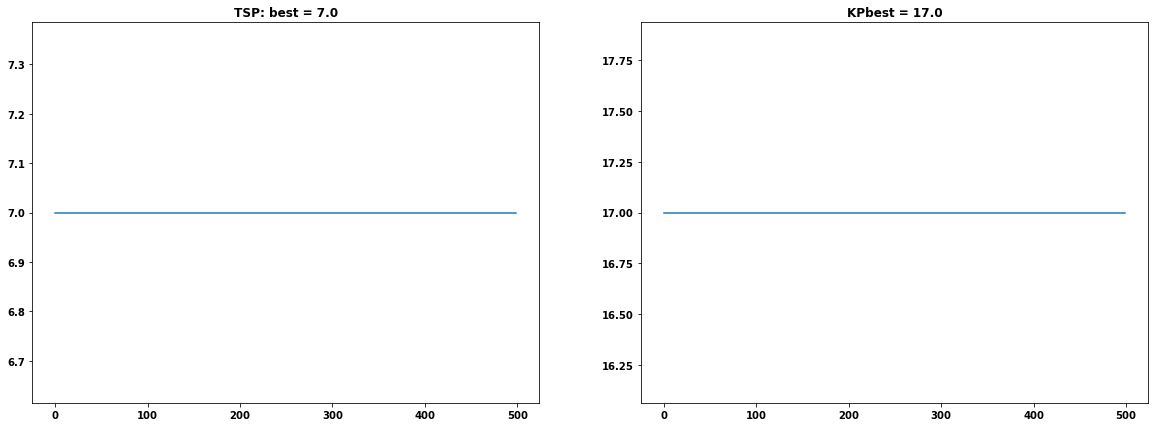

In [18]:
show(history)